In [1]:
import sys

# import seaborn as sns
import numpy as np
from scipy import stats, integrate
import os
import matplotlib as mpl
import matplotlib.ticker as tk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import re
from copy import deepcopy
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import pandas as pd
import scipy.interpolate as interpolate
import json

plt.rcParams.update({'font.size': 18})
sys.path.append('/home/jtb34/GitHub/GACF/')
#sys.path.append('/home/jtb34/python27')
# print sys.path
from NGTS.NGTS_Field import return_field_from_object_directory, NGTSField
from NGTS.GACF_utils import TIME_CONVERSIONS
import NGTS.GACF_utils as utils

ROOT_DIR = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS'

/home/jtb34/GitHub/GACF/NGTS/NGTS_Field.py:11: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")
/home/jtb34/GitHub/GACF/NGTS/GACF_utils/ngtsio_utils.py:10: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")


In [2]:
from astropy.time import Time
from astropy.coordinates import get_moon, get_sun, SkyCoord, EarthLocation, AltAz
import astropy.units as u
def moon_phase_angle(time, ephemeris=None):
    """
    Calculate lunar orbital phase in radians.

    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation

    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).

    Returns
    -------
    i : float
        Phase angle of the moon [radians]
    """
    # TODO: cache these sun/moon SkyCoord objects

    sun = get_sun(time)
    moon = get_moon(time, ephemeris=ephemeris)
    elongation = sun.separation(moon)
    return np.arctan2(sun.distance*np.sin(elongation),
                      moon.distance - sun.distance*np.cos(elongation))

def moon_illumination(time, ephemeris=None):
    """
    Calculate fraction of the moon illuminated.

    Parameters
    ----------
    time : `~astropy.time.Time`
        Time of observation

    ephemeris : str, optional
        Ephemeris to use.  If not given, use the one set with
        `~astropy.coordinates.solar_system_ephemeris` (which is
        set to 'builtin' by default).

    Returns
    -------
    k : float
        Fraction of moon illuminated
    """
    i = moon_phase_angle(time, ephemeris=ephemeris)
    k = (1 + np.cos(i))/2.0
    return k.value

In [3]:
XMATCH_LOCATION = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS/{}/cross_match/'
XMATCH_FILE_NAME = 'Uncut_Final_{}.fits'
def load_gaia_params(field):
    xmatch_path = os.path.join(XMATCH_LOCATION.format(field.fieldname),
                               XMATCH_FILE_NAME.format(field.fieldname))
    if not os.path.exists(xmatch_path):
        print xmatch_path, 'does not exist'
        return field

    with fits.open(xmatch_path) as gfits:
        for i, obj in enumerate(gfits[1].data['Sequence_number']):
            if obj in field.objects:
                field[obj].Gaia_Teff = gfits[1].data['Gaia_Teff'][i]
                field[obj].Gaia_Radius = gfits[1].data['Gaia_Radius'][i]
                field[obj].Gaia_Lum = gfits[1].data['Gaia_Lum'][i]
                field[obj].Gaia_Parallax = gfits[1].data['Gaia_Parallax'][i]
                field[obj].TWOMASS_Hmag = gfits[1].data['2MASS_Hmag'][i]
                field[obj].TWOMASS_Kmag = gfits[1].data['2MASS_Kmag'][i]
                field[obj].APASS_Vmag = gfits[1].data['APASS_Vmag'][i]
                field[obj].APASS_Bmag = gfits[1].data['APASS_Bmag'][i]
                field[obj].Gaia_Gmag = gfits[1].data['Gaia_Gmag'][i]
                field[obj].NGTS_I_3 = gfits[1].data['NGTS_I_3'][i]
                field[obj].NGTS_I_4 = gfits[1].data['NGTS_I_4'][i]
                field[obj].NGTS_I_5 = gfits[1].data['NGTS_I_5'][i]
                field[obj].NGTS_I_6 = gfits[1].data['NGTS_I_6'][i]
                field[obj].BminusV = field[obj].APASS_Bmag - field[obj].APASS_Vmag
                field[obj].HminusK = field[obj].TWOMASS_Hmag - field[obj].TWOMASS_Kmag
                field[obj].GminusK = field[obj].Gaia_Gmag - field[obj].TWOMASS_Kmag
#         print gfits[1].header

    return field

def find_fits_file(directory=None):
    if directory is None:
         directory = os.getcwd()
    string_pattern = r'^(?P<fieldname>\w+?[+-]\w+?)_\d+_[\w\-/,]+_(?P<test>\w+).fits$'
    pattern = re.compile(string_pattern)
    for f in os.listdir(directory):
        match = re.match(pattern, f)
        if match is not None:
            return f if directory is None else os.path.join(directory, f), match.group('fieldname'), match.group('test')
        
    raise IOError('File not found in directory {}'.format(directory))
    
# field.load_from_fits(fits_file, obj_ids=object_list, method='fitsio')

In [4]:
now = Time.now()

In [4]:
moon = get_moon(now)

In [5]:
moon

<SkyCoord (GCRS: obstime=2019-04-01 14:43:56.545265, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, km)
    (332.88142045, -14.3752137, 405392.001874)>

In [104]:
fieldname = 'NG2346-3633'
# fieldname = 'NG0535-0523'
field_position = '23:46 -36.33'
NGTSFieldCentre = SkyCoord(field_position, unit=(u.hourangle, u.deg), frame='gcrs')
print NGTSFieldCentre

<SkyCoord (GCRS: obstime=J2000.000, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec) in deg
    (356.5, -36.33)>


In [5]:
ra_rad = [m.ra.wrap_at(180 * u.deg).radian for m in moon_sep]
dec_rad = [m.dec.radian for m in moon_sep]
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111, projection='aitoff')
plt.title("Aitoff projection of moon")
plt.grid(True)
plt.plot(ra_rad, dec_rad, 'o', markersize=2, alpha=0.3)
plt.plot(NGTSFieldCentre.ra.wrap_at(180*u.deg).radian, NGTSFieldCentre.dec.radian, 'o', markersize=10, c='r')
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.show()
# c = ax.scatter([m.deg for m in moon_sep], np.linspace(1,1,len(ts)),c=ts)
# plt.show()

NameError: name 'moon_sep' is not defined

In [ ]:
plt.plot(ts,[np.cos(m) for m in moon_sep])
plt.show()

In [ ]:
from GACF import find_correlation_from_lists_cpp
lt, c, _ = find_correlation_from_lists_cpp(ts, [float(np.cos(m)) for m in moon_sep])

In [ ]:
plt.plot(lt, c)
plt.axvline(x=28)
plt.show()

In [ ]:
NGTSFieldCentre.distance

In [ ]:

loc

In [ ]:
plt.scatter(ts, [m.arcminute for m in moon_sep])

In [84]:
fieldname = 'NG2346-3633'
# fieldname = 'NG0535-0523'
# fieldname = 'NG0004-2950'
object_pattern = re.compile(r'^(?P<obj>\d+)_VERSION_CYCLE1807$')
logfile = '{}_VERSION_CYCLE1807/peaks.log'
obj_list = []
for f in os.listdir(os.path.join(ROOT_DIR, fieldname)):
    match = re.match(object_pattern, f)
    if match is not None:
        obj_list.append(int(match.group('obj')))
obj_list = np.array(obj_list)
print 'Found {} objects'.format(len(obj_list))
logfiles = []
# obj_id = obj_list[np.random.randint(0, len(obj_list), size=50)]
obj_id = obj_list
for o in obj_id:
    path = os.path.join(*[ROOT_DIR, fieldname, logfile.format(o)])
    if os.path.exists(path):
        logfiles.append((o, path))
# print logfiles
# obj_id = [30]
print obj_id
# field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', obj_ids=obj_id)
# obj = field[field.objects.keys()[0]]

Found 3421 objects
[2648 1277 6532 ... 8261 3904 3849]


matched 8957 of 9353 files. Loaded 1 objects


In [91]:
new_moon_epoch = field.get_new_moon_epoch()

[8374] 29.05
matched 3421 of 3596 files. Loaded 1 objects


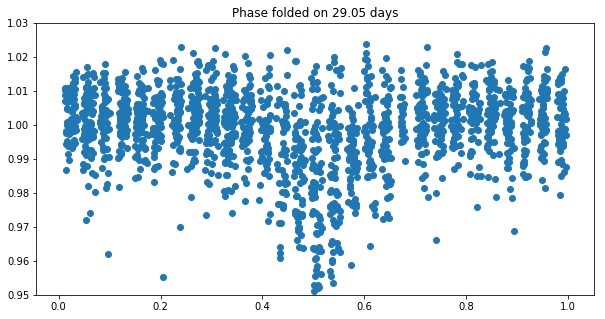

In [113]:
# i = np.random.randint(0, len(moon_objs)-1)
obj_id = [moon_objs[i]]
p = moon_periods[i]
print obj_id, p
# obj_id = [19246]
field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', obj_ids=obj_id)
fits_file,_,_ = find_fits_file(directory=field.filename)
field.load_from_fits(fits_file, obj_ids=obj_id, method='fitsio', sparse_ids=True)
field = load_gaia_params(field)
obj = field[field.objects.keys()[0]]
fig, ax = plt.subplots(figsize=(10,5))
ax.set_ylim([0.95, 1.03])
# p = obj.cleaned_refined_periods[0]
# p = obj.periods[0]
# p = 27.723
t = obj.timeseries_binned
f = obj.flux_binned
phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
ax.scatter(phase_app, data_app)
ax.set_title('Phase folded on {} days'.format(p))
plt.show()

In [85]:
moon_text_pattern = re.compile(r'Moon period removed: (\d+\.*\d*) days')
moon_periods = []
moon_objs = []
moon_up = []
for lf in logfiles:
    with open(lf[1], 'r') as f:
        log = f.read()
        if 'Moon period removed' in log:
            match = re.search(moon_text_pattern, log)
            if match:
                moon_periods.append(float(match.group(1)))
                moon_objs.append(lf[0])
            if 'MOON SIGNAL LOWER' in log:
                moon_up.append('LOWER')
            elif 'MOON SIGNAL HIGHER' in log:
                moon_up.append('HIGHER')
            else:
                moon_up.append(None)
#             print 'MOON REMOVED', log
#     print log
# print moon_periods

In [86]:
print '\n'.join(map(str,zip(moon_objs, moon_periods)))

(6532, 29.843)
(6726, 28.151)
(4602, 28.151)
(263, 27.864)
(3263, 28.593)
(6821, 30.007)
(939, 28.151)
(9333, 28.896)
(6055, 28.007)
(3707, 28.007)
(2292, 28.444)
(66, 28.744)
(6116, 28.444)
(2265, 29.362)
(2715, 28.593)
(5587, 29.843)
(11898, 28.593)
(3695, 28.297)
(9889, 30.007)
(7940, 28.593)
(2495, 28.297)
(7446, 28.151)
(5010, 28.744)
(3685, 28.896)
(348, 28.744)
(2641, 28.593)
(4731, 29.05)
(6393, 28.444)
(1392, 30.682)
(6300, 31.03)
(9437, 28.896)
(1239, 29.843)
(1645, 27.723)
(1821, 28.896)
(3687, 29.205)
(3867, 28.297)
(8439, 28.744)
(3802, 28.444)
(3757, 28.593)
(9758, 28.896)
(12077, 28.593)
(6228, 28.007)
(9140, 29.681)
(10314, 28.593)
(11146, 28.744)
(5253, 27.723)
(182, 29.521)
(2996, 28.896)
(11406, 28.896)
(7827, 28.297)
(1725, 28.007)
(8726, 29.681)
(6173, 29.521)
(10735, 28.007)
(2952, 30.341)
(11742, 28.744)
(1764, 28.896)
(9565, 28.896)
(10697, 30.341)
(8926, 28.151)
(1988, 28.593)
(3905, 29.205)
(5804, 29.843)
(2507, 28.593)
(5059, 28.007)
(8066, 28.297)
(1749, 28.

In [99]:
len(moon_objs)

1267

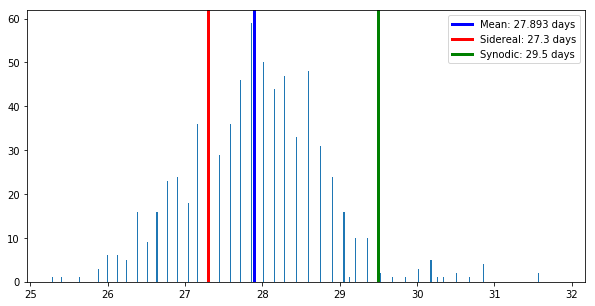

In [57]:
len(moon_periods)
bin_width = 20 * TIME_CONVERSIONS['m2d']
bin_edges = np.arange(min(moon_periods), max(moon_periods), bin_width)
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(moon_periods, bins=bin_edges)
ax.axvline(x=np.mean(moon_periods), c='b', lw=3, label='Mean: {:.3f} days'.format(np.mean(moon_periods)))
ax.axvline(x=27.3, c='r', lw=3, label='Sidereal: 27.3 days')
ax.axvline(x=29.5, c='g', lw=3, label='Synodic: 29.5 days')
plt.legend()
plt.show()

In [6]:
plt.scatter(obj.timeseries_binned, obj.flux_binned, s=0.2)

plt.scatter(obj.timeseries_binned, obj.flux_binned_old, s=0.2)

NameError: name 'obj' is not defined

In [105]:
loc = EarthLocation.of_site('Cerro Paranal')
tmed =  np.median(obj.timeseries_binned)
ts = np.linspace(min(obj.timeseries_binned), max(obj.timeseries_binned), 200)
# print loc
moon_sep = [get_moon(Time(t + utils.NGTS_EPOCH, format='jd'), location=loc).separation(NGTSFieldCentre) for t in ts]
moon_illum = [moon_illumination(Time(t + utils.NGTS_EPOCH, format='jd')) for t in ts]
# moon_sep2 = [get_moon(Time(t + utils.NGTS_EPOCH, format='jd')) for t in ts]
# print moon_sep
# print moon_sep2

In [17]:
# moon_illum = [moon_illumination(Time(t + utils.NGTS_EPOCH, format='jd')) for t in ts]

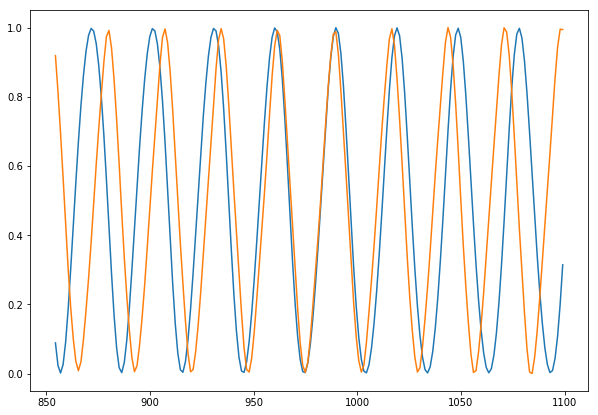

In [106]:
moon_sep_scaled = [m.radian for m in moon_sep]
moon_sep_scaled = ((np.array(moon_sep_scaled) - min(moon_sep_scaled)))
moon_sep_scaled = (moon_sep_scaled / max(moon_sep_scaled) - 1.0 )* -1.0
fig, ax = plt.subplots(figsize=(10,7))
# ax1 = ax.twinx()
# ax.scatter(obj.timeseries_binned, obj.flux_binned, s=0.2)
# ax1.plot(ts, [m.radian for m in moon_sep])
ax.plot(ts, moon_illum)
ax.plot(ts, moon_sep_scaled)
plt.show()

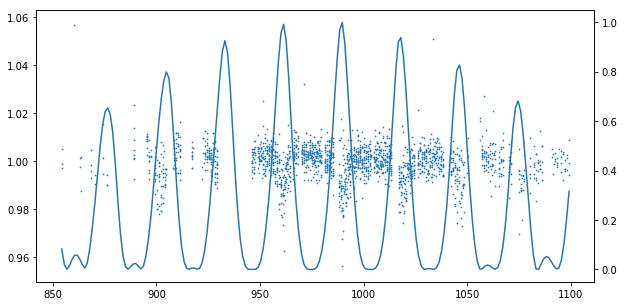

In [111]:
moonbright = [m[0] * m[1] for m in zip(moon_sep_scaled, moon_illum)]
mm = max(moonbright)
moonbright = [m/mm for m in moonbright]
fig, ax = plt.subplots(figsize=(10,5))
ax1 = ax.twinx()
# ax.set_ylim([0.8, 1.2])
# ax.scatter(obj.timeseries_binned, obj.flux_binned, s=0.5)
# ax1.plot(ts, moonbright)
# ax1.plot(ts, rads)
plt.show()

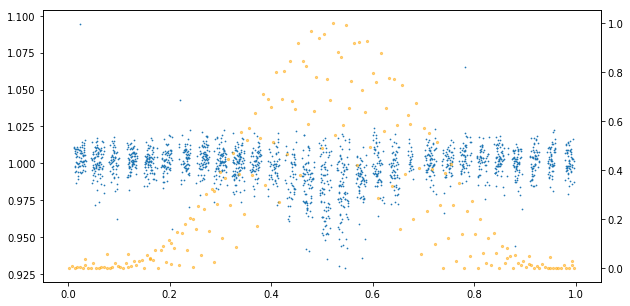

In [117]:
fig, ax = plt.subplots(figsize=(10,5))
ax1 = ax.twinx()
# ax.set_ylim([0.8, 1.2])
phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
ax.scatter(phase_app, data_app, s=0.5)
phase_app1, data_app1 = utils.append_to_phase(utils.create_phase(ts, p, new_moon_epoch), moonbright, 0)
ax1.scatter(phase_app1, data_app1, s=5, c='orange', alpha=0.5)
# ax1.plot(ts, rads)
plt.show()

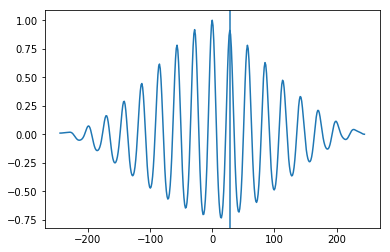

In [109]:
from GACF import find_correlation_from_lists_cpp
lt, c, _ = find_correlation_from_lists_cpp(ts, moonbright)
plt.plot(lt, c)
plt.axvline(x=28.5)
plt.show()

In [110]:
altaz = [AltAz(obstime=Time(t + utils.NGTS_EPOCH, format='jd'), location=loc) for t in ts]
moons = [get_moon(Time(t + utils.NGTS_EPOCH, format='jd')) for t in ts]
moonp = [moon.transform_to(altaz[i]) for i, moon in enumerate(moons)]

In [ ]:
rads = np.array([float(m.alt.radian) for m in moonp])
idx_ok = np.argwhere(np.array(moonp) > 0)
rads[idx_ok]

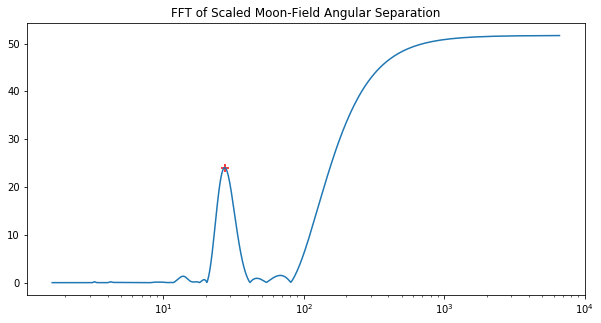

[27.32903053]


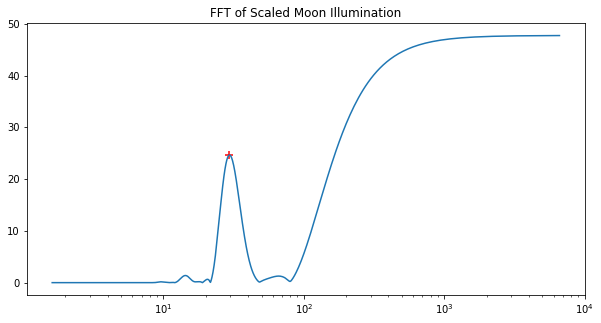

[29.52511334]


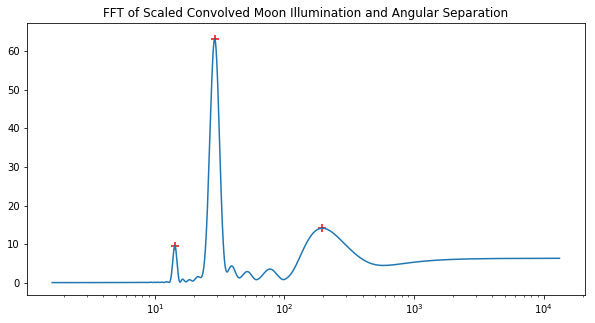

[194.51839377  28.94365597  14.2842881 ]


In [98]:
from scipy.signal import hann
ft1, p1, i1 = utils.fourier_transform_and_peaks(moon_sep_scaled * hann(len(ts)), ts)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(p1, ft1)
ax.set_xscale('log')
ax.set_title('FFT of Scaled Moon-Field Angular Separation')
# ax.set_xlim([0.01, 1000])
ax.scatter(p1[i1], ft1[i1], marker='+', c='r', s=50)
plt.show()
print p1[i1]

ft1, p1, i1 = utils.fourier_transform_and_peaks(moon_illum * hann(len(ts)), ts)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(p1, ft1)
ax.set_xscale('log')
ax.set_title('FFT of Scaled Moon Illumination')
# ax.set_xlim([0.01, 1000])
ax.scatter(p1[i1], ft1[i1], marker='+', c='r', s=50)
plt.show()
print p1[i1]

ft1, p1, i1 = utils.fourier_transform_and_peaks(c, lt)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(p1, ft1)
ax.set_xscale('log')
ax.set_title('FFT of Scaled Convolved Moon Illumination and Angular Separation')
# ax.set_xlim([0.01, 1000])
ax.scatter(p1[i1], ft1[i1], marker='+', c='r', s=50)
plt.show()
print p1[i1]

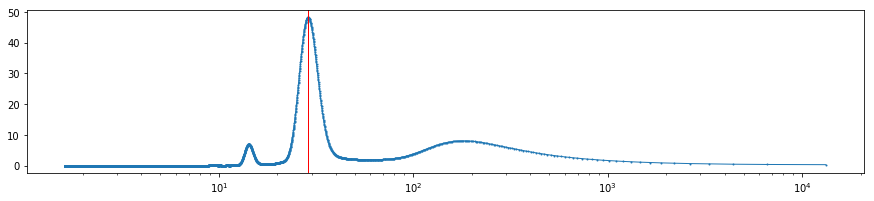

Out: [ 28.75489299 181.19521612  14.25350299]


28.754892992479324

In [113]:
refine_period(np.array(lt), np.array(c), 28.94365597)

In [111]:
def refine_period(t, x, p, n=5):
    idxs = np.where(np.abs(t) < n * p)[0]
    x2 = np.array(x)[idxs]
    t2 = np.array(t)[idxs]

    hm = np.hamming(len(x2))
    x2 = hm * x2

    ft2, p2, i2 = utils.fourier_transform_and_peaks(x2, t2)
    ps2 = np.array([pair[0] for pair in sorted([q for q in zip(p2[i2], ft2[i2])], key=lambda x: x[1], reverse=True)])
    pc = ps2[np.argmin(np.abs(ps2 - p))]

    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(p2, ft2, marker='o', ms=1, lw=1)
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.axvline(x=pc, lw=1, c='r')
    plt.show()
    print 'Out:', ps2

    return pc

In [13]:
fieldg = NGTSField(fieldname=fieldname, test='CYCLE1807', object_list=moon_objs)
fieldg = load_gaia_params(fieldg)
moonsup = []
moonsdown = []
for o, up in zip(moon_objs, moon_up):
    fieldg[o].moon_up = up
    if up == 'HIGHER':
        moonsup.append(fieldg[o].NGTS_I_3)
    elif up == 'LOWER':
        moonsdown.append(fieldg[o].NGTS_I_3)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1104 / length of dimension 1                          NAXIS2  =                 8957 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                  147 / number of table fields                         TTYPE1  = 'Sequence_number'                                                     TFORM1  = 'D       '                                                            TTYPE2  = 'RA_DEG  '                                                            TFORM2  = 'D       '                                                            TTYPE3  = 'DEC_DEG '                    

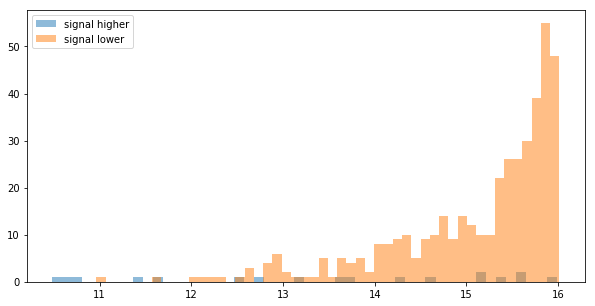

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(moonsup, bins=50, alpha=0.5, label='signal higher')
plt.hist(moonsdown, bins=50, alpha=0.5, label='signal lower')
plt.legend()
plt.show()

In [15]:
for obj in fieldg:
    try:
        print obj.moon_up
    except AttributeError:
        print 'YEET'

None
LOWER
LOWER
HIGHER
LOWER
LOWER
LOWER
LOWER
None
LOWER
None
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
HIGHER
LOWER
LOWER
None
LOWER
LOWER
None
HIGHER
LOWER
LOWER
HIGHER
LOWER
None
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
None
None
None
None
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
HIGHER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
None
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
None
None
LOWER
LOWER
LOWER
None
LOWER
None
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
LOWER
None
LOWER
LOWER
LOWER
HIGHER
LOWER
LOWER
None
None
LOWER
N

In [9]:
# load half moon periods
with open('/home/jtb34/rds/hpc-work/GACF_OUTPUTS/NG0535-0523/NGTS_Field_NG0535-0523_pdic.json', 'r') as f:
    pdic = json.load(f)

pdic = {int(k):v for k,v in pdic.iteritems()}
# print pdic

half_moon_objs = [(k, v[0]) for k,v in pdic.iteritems() if 13<v[0]<15]
print half_moon_objs


[(32796, 14.922), (74, 14.185), (8292, 14.841), (501, 14.259), (516, 14.642), (16917, 14.41), (787, 14.334), (33699, 13.791), (1026, 13.552), (17873, 13.552), (9836, 14.721), (2013, 14.841), (35107, 14.525), (27018, 13.619), (2453, 14.486), (35317, 14.149), (18951, 14.334), (10811, 14.112), (10979, 14.259), (11073, 14.149), (11154, 14.149), (27634, 13.32), (28054, 13.968), (19988, 13.968), (28225, 13.897), (3833, 13.452), (20225, 14.334), (28441, 14.149), (12158, 14.881), (4075, 14.41), (12395, 13.034), (7541, 13.485), (29049, 13.757), (29076, 14.076), (29146, 14.721), (4748, 14.185), (21359, 14.259), (30002, 14.185), (30079, 14.642), (5867, 14.841), (5924, 14.297), (30680, 13.897), (14354, 13.826), (3769, 14.149), (6419, 13.386), (6468, 14.602), (31235, 14.602), (14926, 13.419), (23262, 14.259), (15286, 13.192), (31821, 13.861), (23970, 14.681), (32359, 14.963), (16080, 14.41), (8085, 13.353)]


In [8]:
def do_plots(obj):
    n=4
    fig, ax = plt.subplots(2,2, figsize=(10, 5))
    ax[0,0].scatter(obj.timeseries_binned, obj.flux_binned, s=0.5)
    ax[1,0].scatter(obj.lag_timeseries, obj.correlations, s=0.5)
    ft_max = max(obj.ft)
    ax[0,1].plot(obj.period_axis, obj.ft/ft_max, lw=0.5, marker='.', ms=0.5)
    ax[0,1].set_xscale('log')
    ax[0,1].set_xlim(right=100)
    ax[0,1].scatter(obj.period_axis[obj.peak_indexes], obj.ft[obj.peak_indexes]/ft_max, marker='+', s=40, c='r')
    peaks = obj.ft[obj.peak_indexes] / ft_max
    peaksplot = np.linspace(1, len(peaks), len(peaks))
    ax[1,1].scatter(peaksplot, peaks)
    ft_ave = np.mean(obj.ft) / ft_max
    peaks_ave = np.mean(peaks)
    ax[1,1].axhline(y=ft_ave, c='g', label='FT mean')
    ax[1,1].axhline(y=peaks_ave, c='r', label='Peaks mean')
    plt.show()
    p = obj.cleaned_refined_periods[0]
    t = obj.timeseries_binned
    f = obj.flux_binned
    phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, new_moon_epoch), f, 0)
    binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    ndata = len(phase_app)
    idx = [i for i in range(1,ndata) if phase_app[i]<phase_app[i-1] ]
    idx.append(ndata-1)
    nidx = len(idx)
    colours = mpl.cm.rainbow(np.r_[0:1:nidx*1j])
    phases, fs = [], []
    j=0
    for k,i in enumerate(idx):
        phases.append( np.array(phase_app[j:i]) )
        fs.append( np.array(f[j:i]) )
        ax.scatter(phases[k], fs[k], marker='o', s=1, c=colours[k])
        j=i
    
#     ax.scatter(phase_app, data_app, s=0.1)
    ax.scatter(binned_phase_app, binned_data_app, marker='+', s=5, c='k')
    ax.axvline(x=0, lw=0.1, c='k', ls='--')
    ax.axvline(x=1, lw=0.1, c='k', ls='--')
    ax.set_title('Data phase folded on {} day period'.format(p))
    plt.show()

In [13]:
def get_new_moon_epoch(timeseries):
    med_time = np.median(timeseries)
    moon_time = np.linspace(med_time - 30, med_time + 30, 100)
    moons = [moon_illumination(Time(t + utils.NGTS_EPOCH, format='jd')) for t in moon_time]
    moon_epoch = Time(moon_time[np.argmin(moons)], format='jd').jd
#     fig, ax = plt.subplots(figsize=(10,5))
#     ax.plot(moon_time, moons)
#     ax.axvline(x=moon_time[np.argmin(moons)])
    return moon_epoch, moon_time, moons

new_moon_epoch, moon_time, moons = get_new_moon_epoch(field[field.objects.keys()[0]].timeseries_binned)

In [11]:
field = return_field_from_object_directory(ROOT_DIR, fieldname, test='CYCLE1807', obj_ids=[o[0] for o in half_moon_objs])
field = load_gaia_params(field)


matched 8957 of 9346 files
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1104 / length of dimension 1                          NAXIS2  =                 8957 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                  147 / number of table fields                         TTYPE1  = 'Sequence_number'                                                     TFORM1  = 'D       '                                                            TTYPE2  = 'RA_DEG  '                                                            TFORM2  = 'D       '                                                            TTYPE3  = 'DE

TypeError: 'NoneType' object is not iterable

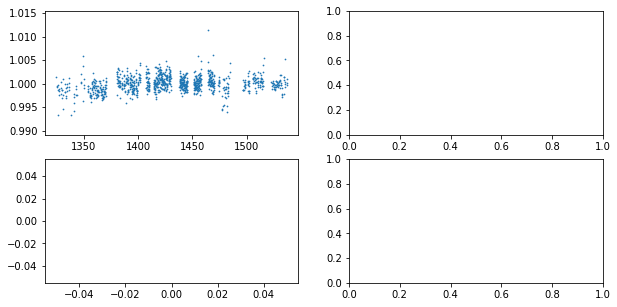

In [9]:
for obj in field:
    do_plots(obj)